In [91]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [92]:
titanic_data = pd.read_csv('../data/train.csv')
titanic_test = pd.read_csv('../data/test.csv')

In [93]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [94]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [95]:
titanic_data.drop(["Cabin","PassengerId"],axis=1,inplace=True) #PassengerId has no effect at all to the surviving status
titanic_test.drop(["Cabin","PassengerId"],axis=1,inplace=True)

In [96]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


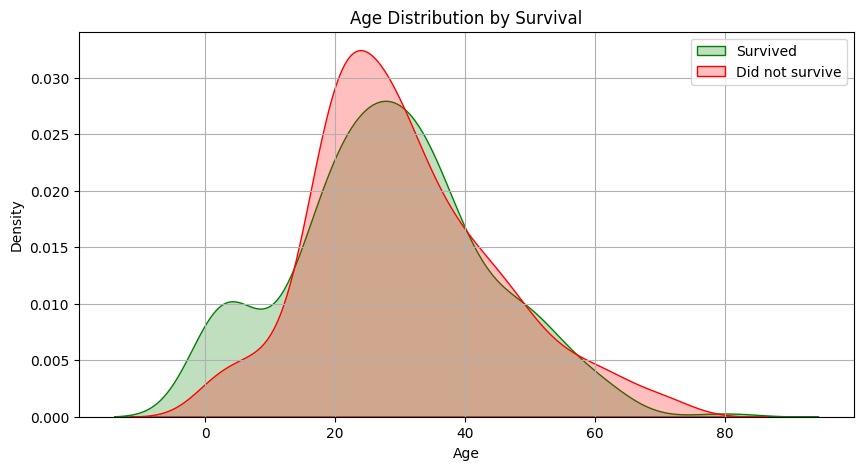

In [97]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=titanic_data[titanic_data['Survived'] == 1]['Age'].dropna(), label='Survived', fill=True, color='green')
sns.kdeplot(data=titanic_data[titanic_data['Survived'] == 0]['Age'].dropna(), label='Did not survive', fill=True, color='red')
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

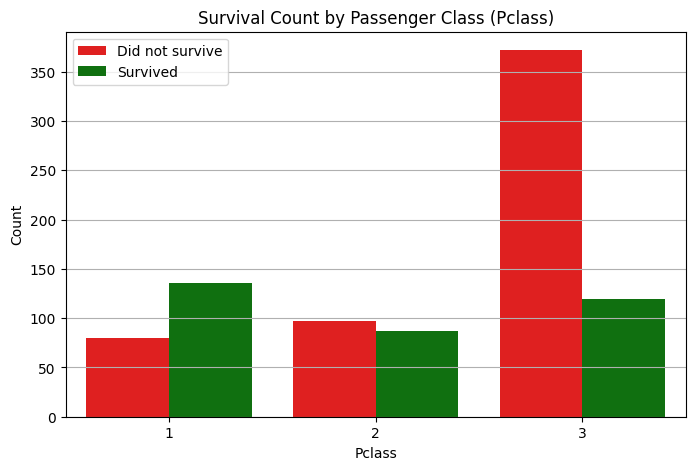

In [98]:
plt.figure(figsize=(8, 5))
sns.countplot(data=titanic_data, x='Pclass', hue='Survived', palette={0: 'red', 1: 'green'})
plt.title('Survival Count by Passenger Class (Pclass)')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.legend(['Did not survive', 'Survived'])
plt.grid(axis='y')
plt.show()


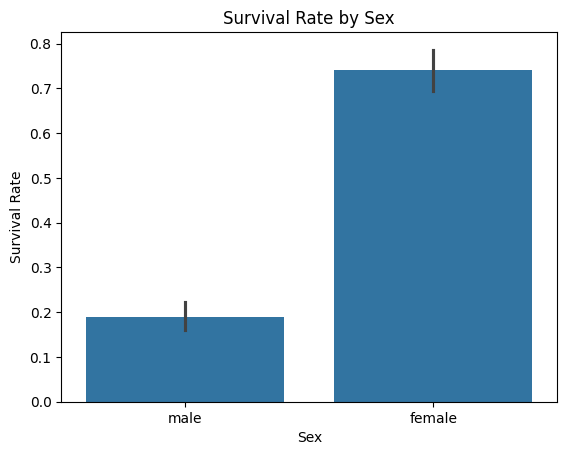

In [99]:
sns.barplot(x='Sex', y='Survived', data=titanic_data)
plt.title("Survival Rate by Sex")
plt.ylabel("Survival Rate")
plt.show()

In [100]:
X_train = titanic_data.drop('Survived',axis=1)
Y_train = titanic_data["Survived"]
X_test = titanic_test

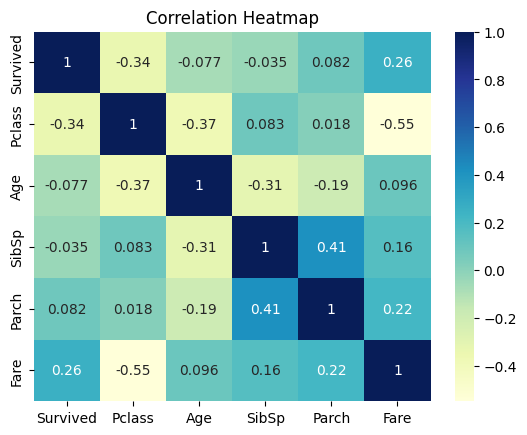

In [101]:
numeric_df = titanic_data.select_dtypes(include='number')
sns.heatmap(numeric_df.corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation Heatmap")
plt.show()

Just to make sure that the training and testing sets have similar distributions of the most corrolated features , we use StratifiedShuffleSplit:

In [102]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_indices , test_indices in split.split(titanic_data,titanic_data[["Survived","Pclass","Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

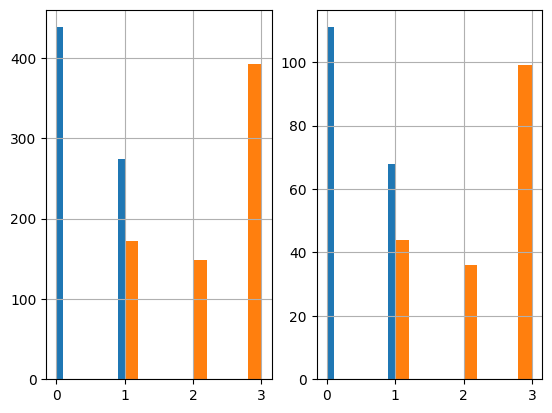

In [103]:
plt.subplot(1,2,1)
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()

plt.subplot(1,2,2)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()

plt.show()

In [104]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_features = ["Age","Fare"]
categorical_features = ["Sex", "Embarked", "Pclass"]

In [105]:
numeric_transformer = Pipeline(steps=[
    ("impuer",SimpleImputer(strategy="median",))
])

In [106]:
categorical_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot",OneHotEncoder(handle_unknown="ignore"))
])

In [107]:
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ( "cat" , categorical_transformer,categorical_features)
])

In [108]:
from sklearn.ensemble import RandomForestClassifier

model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier())
])


In [109]:
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 5, 10],
    "classifier__min_samples_split": [2, 5, 10]
}

In [110]:
x_strat_train =  strat_train_set.drop("Survived", axis=1)
y_strat_train = strat_train_set["Survived"]
x_strat_test =  strat_test_set.drop("Survived", axis=1)
y_strat_test = strat_test_set["Survived"]

In [111]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    verbose=2,  
    n_jobs=-1  
)

grid_search.fit(x_strat_train, y_strat_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


,estimator,Pipeline(step...lassifier())])
,param_grid,"{'classifier__max_depth': [None, 5, ...], 'classifier__min_samples_split': [2, 5, ...], 'classifier__n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [112]:
print(f"Best parameters : {grid_search.best_params_}\n")
print(f"Best score : {grid_search.best_score_}")

best_model = grid_search.best_estimator_

Best parameters : {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Best score : 0.8412587412587413


In [113]:
y_pred = best_model.predict(x_strat_test)

print("Accuracy:", accuracy_score(y_strat_test, y_pred))
print("Precision:", precision_score(y_strat_test, y_pred))
print("Recall:", recall_score(y_strat_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_strat_test, y_pred))
print("Classification Report:\n", classification_report(y_strat_test, y_pred))

Accuracy: 0.8156424581005587
Precision: 0.7868852459016393
Recall: 0.7058823529411765
Confusion Matrix:
 [[98 13]
 [20 48]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86       111
           1       0.79      0.71      0.74        68

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179



Now let us train the model on the whole train.csv and test it on test.csv

In [114]:
best_model.fit(X_train,Y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [115]:
Y_predict_final = best_model.predict(X_test)

In [116]:
print(Y_predict_final)

[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


Insights :

1. Gender-Based Survival:

Female passengers had a much higher survival rate than males. This indicates that during the evacuation, women were prioritized—possibly due to the "women and children first" policy.

2. Fare Correlation:

Higher ticket fares were slightly associated with higher survival rates, suggesting that passengers who paid more may have had better access to lifeboats or cabins closer to safety.

3. Age and Survival:

Children (especially under age 10) had a noticeably higher survival rate than adults. This supports the historical claim that children were also given priority during evacuation.

4. Class and Survival:

first-class passengers had the highest chance of survival.